**Notebook credit**: Based on the original D2L notebook [here](https://github.com/d2l-ai/d2l-en-colab/blob/master/chapter_convolutional-neural-networks/conv-layer.ipynb).


# Convolutions for Images




## The Cross-Correlation Operation (交叉相关)

**严格意义上, 我们这里写的 convolutional layers 并不是严谨的, 实际上我们进行的操作在数学上不叫 convolution, 而是叫 cross-correlations(交叉相关).**

Let us ignore channels for now and see how this works with two-dimensional data and hidden representations.
In the figure below, the input is a two-dimensional tensor with a height of 3 and width of 3.
We mark the shape of the tensor as $3 \times 3$ or ($3$, $3$). The height and width of the kernel are both 2. The shape of the *kernel window* (or *convolution window*) is given by the height and width of the kernel.(here it is $2 \times 2$).

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)


在 2d cross-correlation operation 运算中，我们首先将conv kernel 置于 input tensor 的左上角, 然后在 input tensor 上从左到右, 从上到下滑动. 当 conv kernel 滑动到某个位置时, 该窗口中包含的每个 entry 与 conv kernel 重合的部分进行元素相乘, 然后将结果相加, 得到一个单一的标量值, 这个结果就是 output tensor 相应位置的值.

这个例子中这里, input tensor 的 height 为 2, width 为 2, 于是 output tensor 的每个 entry 的值:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$


### output size 的计算公式
Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than one,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_h \times n_w$
minus the size of the convolution kernel $k_h \times k_w$
via

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.
Later we will see how to keep the size unchanged
by padding the image with zeros around its boundary
so that there is enough space to shift the kernel.
Next, we implement this process in the `corr2d` function,
which accepts an input tensor `X` and a kernel tensor `K`
and returns an output tensor `Y`.

这个公式还是很自然的. 因为 kernel 在一个方向上越大, 滑动结束的就越早.


In [1]:
import numpy as np
import tensorflow as tf

### `corr2d` Cross-Correlation 运算的 implementation

In [2]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = tf.Variable(tf.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j].assign(tf.reduce_sum(
                X[i: i + h, j: j + w] * K)) # * 表示逐元素 multiple,
    return Y

We can construct the input tensor `X` and the kernel tensor `K`
from the figure above
to **validate the output of the above implementation**
of the two-dimensional cross-correlation operation.


In [3]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = tf.constant([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K).numpy()

array([[19., 25.],
       [37., 43.]], dtype=float32)

## Convolutional Layers 的 python implementation

A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output.

The two parameters of a convolutional layer
are the kernel and the scalar bias. When training models based on convolutional layers, we typically initialize the kernels randomly, just as we would with a fully-connected layer.

We are now ready to **implement a two-dimensional convolutional layer** based on the `corr2d` function defined above.

In the `build()` method, we set `weight` and `bias` as the two model parameters.

The `call()` method calls the `corr2d` function and adds the bias.


In [16]:
# member vairable: weight 和 bias. weight 也就是 kernel
# build 方法是 initialize weight 和 bias 为固定形状的随机 tensor (值随机, 形状要自己定)
# call 方法是把 input 喂进来输出 Convolutional Layer 的 Output.
class Conv2D(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, kernel_size):
        initializer = tf.random_normal_initializer()
        self.weight = self.add_weight(name='w', shape=kernel_size,
                                      initializer=initializer)
        self.bias = self.add_weight(name='b', shape=(1, ),
                                    initializer=initializer)

    def call(self, inputs):
        return corr2d(inputs, self.weight) + self.bias

In
$h \times w$ convolution
or a $h \times w$ convolution kernel,
the height and width of the convolution kernel are $h$ and $w$, respectively.
We also refer to
a convolutional layer with a $h \times w$
convolution kernel simply as a $h \times w$ convolutional layer.


## Object Edge Detection in Images

Let us take a moment to parse [**a simple application of a convolutional layer:
detecting the edge of an object in an image**]
by finding the location of the pixel change.
First, we construct an "image" of $6\times 8$ pixels.
The middle four columns are black (0) and the rest are white (1).


In [17]:
X = tf.Variable(tf.ones((6, 8)))
X[:, 2:6].assign(tf.zeros(X[:, 2:6].shape))
X.numpy()

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]], dtype=float32)

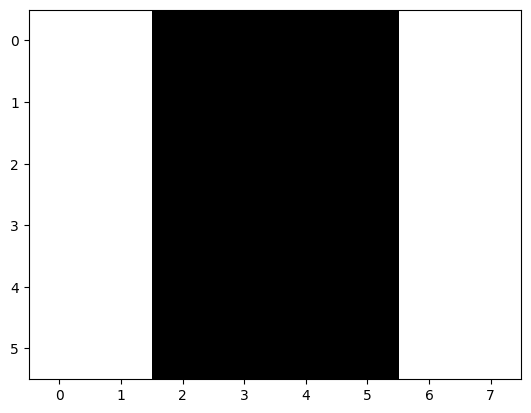

In [18]:
import matplotlib.pyplot as plt
plt.imshow(tf.reshape(X, (6, 8)), cmap="gray")
plt.show()

Next, we construct a kernel `K` with a height of 1 and a width of 2.
When we perform the cross-correlation operation with the input,
if the horizontally adjacent elements are the same,
the output is 0. Otherwise, the output is non-zero.


In [19]:
K = tf.constant([[1.0, -1.0]])

We are ready to perform the cross-correlation operation
with arguments `X` (our input) and `K` (our kernel).
As you can see, **we detect 1 for the edge from white to black
and -1 for the edge from black to white.**
All other outputs take value 0.


In [20]:
Y = corr2d(X, K)
Y.numpy()

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]], dtype=float32)

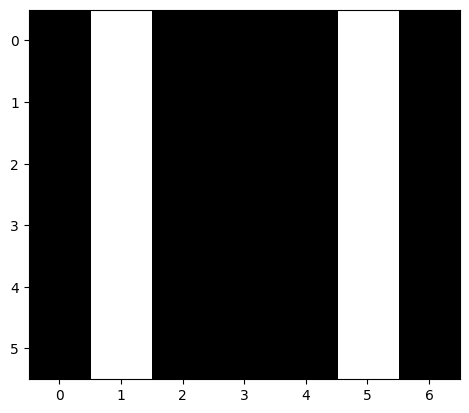

In [21]:
plt.imshow(tf.reshape(tf.abs(Y), (6, 7)), cmap = "gray")
plt.show()

We can now apply the kernel to the transposed image.
As expected, it vanishes. **The kernel `K` only detects vertical edges.**


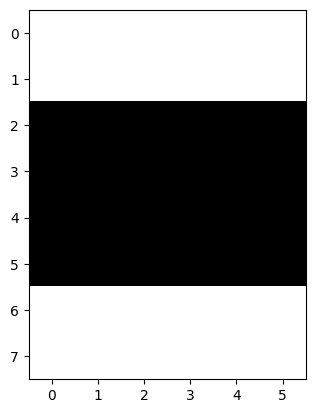

In [22]:
plt.imshow(tf.reshape(tf.transpose(X), (8, 6)), cmap="gray")
plt.show()

In [23]:
Y2 = corr2d(tf.transpose(X), K)
Y2.numpy()

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

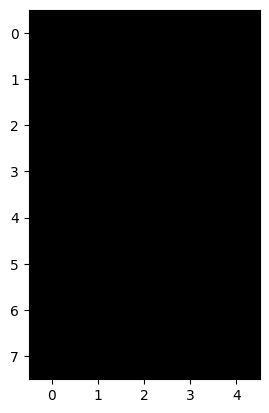

In [24]:
plt.imshow(tf.reshape(tf.abs(Y2), (8, 5)), cmap = "gray")
plt.show()

## Learning a Kernel: 让 model 在 learning 的过程中自己更改 kernel 的 entries 的值.

Designing an edge detector by finite differences `[1, -1]` is neat
if we know this is precisely what we are looking for.
However, as we look at larger kernels,
and consider successive layers of convolutions,
it might be impossible to specify
precisely what each filter should be doing manually.

Now let us see whether we can **learn the kernel that generated `Y` from `X`**
by looking at the input--output pairs only.
We first construct a convolutional layer
and initialize its kernel as a random tensor.
Next, in each iteration, we will use the squared error
to compare `Y` with the output of the convolutional layer.
We can then calculate the gradient to update the kernel.
For the sake of simplicity,
in the following
we use the built-in class
for two-dimensional convolutional layers
and ignore the bias.


In [25]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
# 在我们建立这个 object 的同时, 它完成了 initialization, 现在有随机的 weight 和 bias
conv2d = tf.keras.layers.Conv2D(1, (1, 2), use_bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, height, width, channel), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = tf.reshape(X, (1, 6, 8, 1))
Y = tf.reshape(Y, (1, 6, 7, 1))
lr = 2e-2  # Learning rate

Y_hat = conv2d(X)
for i in range(10):
    with tf.GradientTape() as tape:
        # 当前的 kernel 影响下 Y 的估计值
        Y_hat = conv2d(X)
        # 计算当前的 Y 估计值和实际 Y 的 squared error 作为 loss function
        loss = tf.reduce_sum(tf.abs(Y_hat - Y) ** 2)
        # 计算 loss fucntion 相对于 kernel tensor 的 gradient
        loss_gradient = tape.gradient(loss, conv2d.weights[0])
        # 更新 kernel
        update = tf.multiply(lr, loss_gradient)
        weights = conv2d.get_weights()
        weights[0] = conv2d.weights[0] - update
        conv2d.set_weights(weights)
        if (i + 1) % 2 == 0:
            print(f'epoch {i + 1}, loss {loss:.3f}')

epoch 2, loss 22.212
epoch 4, loss 7.297
epoch 6, loss 2.434
epoch 8, loss 0.812
epoch 10, loss 0.271


Note that the error has dropped to a small value after 10 iterations. Now we will **take a look at the kernel tensor we learned.**


In [26]:
tf.reshape(conv2d.get_weights()[0], (1, 2)).numpy()

array([[ 0.8858046 , -0.88580453]], dtype=float32)

Indeed, the learned kernel tensor is remarkably close
to the kernel tensor `K` we defined earlier.



## Cross-Correlation and Convolution: 对于 deep learning 而言结果(翻折后)相同

回想一下我们之前观察到的交叉相关和卷积操作之间的对应关系. 在这里，让我们继续考虑 2d Convilution Layer: 如果这个 layer 执行的是严格的 Convolution 而不是 cross-correlation operation 呢？**想要得到严格 convolution 的输出, 我们只需要将 2d kernel tensor 进行水平和垂直翻转，然后与 input tensor 进行 cross correlation operation 即可.**

Note that: 由于深度学习中的 kernel 是从数据中学习的, 因此无论 Convolution Layer 执行严格 convolution operation 还是 corss-correlation operation, 其 output 都不会受到影响.

假设有一个 convolutional layer 采用 *cross-correlation* 并且学习了上面的图片, 用 matrix $\mathbf{K}$ 来表示.
并假设另一个 convolutional layer 采用 *convolution*, 其他条件不变, 学习了上面的图片, 用 matrix $\mathbf{K'}$ 来表示. After $\mathbf{K}'$ is flipped both horizontally and vertically, $\mathbf{K}$ 和 $\mathbf{K'}$ 将是相同的.


为了与深度学习文献中的标准术语保持一致，我们将继续把 cross-correlation operation 称为 convolution operation, 尽管严格来说，它略有不同.
此外，我们使用 element 这一词来称呼表示一个 layer representation 或者 convolution kernel 的 tensor 的一个 entry (component).



## Feature Map(特征图) and Receptive Field(感知野)

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](http://d2l.ai/_images/correlation.svg)

一个 ***feature map*** 指的就是某个 input 在 convolutional layer 下的一个 output. 它可以被看作 learned representations (features)
in the spatial dimensions (e.g., width and height) to the subsequent layer.

***receptive field*** 指的对于 CNNs 的某个 layer 中的某个元素, 在这个 layer 前面的 layers 中(即 forward propagation 的过程中)影响这个元素的所有元素的集合.

以上图为例子, output 所在的 layer 中, 值为 $19$ 的这个元素的 receptive field 就包括了 input 的 $0, 1, 3, 4$ 这四个元素. 但是它可能不止于这些元素: 如果前面还有其他的 layers, 那么 $19$ 这个元素的 receptive field 就会更大.

现在，让我们将 $19, 25, 37, 43$ 这个 output 表示为 𝐘, 并考虑一个额外的 convolutional layer, 它将 𝐘 作为 input, 输出单个元素 𝑧。在这种情况下，𝑧对𝐘的 receptive field 包括了 𝐘 的所有四个元素 $19, 25, 37, 43$, 而对更前一层 input 的 receptive field 包括了 $0,...,8$ 这全部 9 个元素.

因此，当 feature map 中的任何元素需要更大的 receptive field 来检测更广阔区域的 input features 时，我们就可以构建一个 deeper network.





## Summary

* The core computation of a two-dimensional convolutional layer is a two-dimensional cross-correlation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.
* We can design a kernel to detect edges in images.
* We can learn the kernel's parameters from data.
* With kernels learned from data, the outputs of convolutional layers remain unaffected regardless of such layers' performed operations (either strict convolution or cross-correlation).
* When any element in a feature map needs a larger receptive field to detect broader features on the input, a deeper network can be considered.


